# Análisis de las vecindades de los píxeles tras la transformación LBP

En primer lugar se realiza la carga de la imagen sobre la que se va a realizar el proceso y se indican los parámetros seleccionados.

In [1]:
from preprocess.preprocess import *
import PARAMETERS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from confusion_matrix_pretty_print import print_confusion_matrix
from main import init_clf_and_fit
import zipfile

%matplotlib inline

PARAMETERS.LBP_METHOD = 'default'
PARAMETERS.METHOD = 'get_pyramid_dataset'
PARAMETERS.INTERPOLATION_ALGORITHM = 'lanczos'
PARAMETERS.BALANCE = False
PARAMETERS.N_SCALES = 5
PARAMETERS.GRAY_INTENSITY = True
PARAMETERS.X2SCALE = True
PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)
PARAMETERS.PLOT = False

pd.DataFrame({k: getattr(PARAMETERS, k) for k in VALID_PARAMETERS.keys()}, index=['Parameters']).head()

,LBP_METHOD,METHOD,INTERPOLATION_ALGORITHM,BALANCE,N_SCALES,GRAY_INTENSITY,X2SCALE
Parameters,default,get_pyramid_dataset,lanczos,False,5,True,True


In [2]:
np.random.seed(0)
def random_kernels(k_len=3, n_samples=5):
    n = k_len * k_len - 1
    k_list = []
    for i in np.round(np.random.rand(n_samples)*n).astype(np.uint8):
        arr = np.array([1]*i+[0]*(n-i))
        np.random.shuffle(arr)
        arr = np.array(list(arr[:n//2]) + [0] + list(arr[n//2:]))
        arr = arr.reshape(k_len, k_len).astype(np.uint8)
        k_list.append(arr)
    return k_list
kernel_list = random_kernels(k_len=3, n_samples=5) + random_kernels(k_len=5, n_samples=5)

In [3]:
from create_db import main

paths = []
for kernel in kernel_list:
    PARAMETERS.CONVOLUTION = ''.join(list(kernel.astype(str).ravel()))
    paths.append(f"../DB/extra_features/convolution/{PARAMETERS.CONVOLUTION}")
    print(PARAMETERS.CONVOLUTION)
    main()

101001010
111100101
100001111
001001110
010101000
1111111111110111111111110
1011011001000000011111101
1100100101000000011000111
0001100000000001100001010
1011111110110101111101011


In [4]:
from pathlib import Path

for i, path in enumerate(paths):
    train_path = list(Path(path).glob('train_train*'))[0]
    test_path = list(Path(path).glob('train_test*'))[0]
    if i == 0:
        df_train_convolutions = pd.read_pickle(train_path, compression='gzip')
        df_train_convolutions.drop(['label'], axis=1, inplace=True)
        df_train_convolutions.columns = [col + '_' + path.split('/')[-1] for col in df_train_convolutions.columns]
        df_test_convolutions = pd.read_pickle(test_path, compression='gzip')
        df_test_convolutions.drop(['label'], axis=1, inplace=True)
        df_test_convolutions.columns = [col + '_' + path.split('/')[-1] for col in df_test_convolutions.columns]
    else:
        df_temp = pd.read_pickle(train_path, compression='gzip')
        df_temp.drop(['label'], axis=1, inplace=True)
        df_temp.columns = [col + '_' + path.split('/')[-1] for col in df_temp.columns]
        df_train_convolutions = pd.concat([df_train_convolutions, df_temp], axis=1)
        df_temp = pd.read_pickle(test_path, compression='gzip')
        df_temp.drop(['label'], axis=1, inplace=True)
        df_temp.columns = [col + '_' + path.split('/')[-1] for col in df_temp.columns]
        df_test_convolutions = pd.concat([df_test_convolutions, df_temp], axis=1)

In [5]:
df_train_convolutions

,Original_101001010,1:1_101001010,1:2_101001010,1:4_101001010,1:8_101001010,2:1_1_101001010,2:1_2_101001010,2:1_3_101001010,2:1_4_101001010,Original_111100101,...,2:1_4_0001100000000001100001010,Original_1011111110110101111101011,1:1_1011111110110101111101011,1:2_1011111110110101111101011,1:4_1011111110110101111101011,1:8_1011111110110101111101011,2:1_1_1011111110110101111101011,2:1_2_1011111110110101111101011,2:1_3_1011111110110101111101011,2:1_4_1011111110110101111101011
0,4,225,225,241,241,225,225,225,225,7,...,17,10,255,221,209,124,1,17,54,159
1,5,225,225,241,241,240,241,225,225,7,...,16,10,255,221,209,124,16,213,207,193
2,5,225,225,1,241,225,225,225,225,8,...,225,10,255,112,247,124,193,241,247,255
3,5,225,225,1,241,225,225,225,225,8,...,113,10,253,112,247,124,247,255,255,255
4,5,225,224,1,241,224,240,225,225,9,...,17,10,241,112,247,124,255,255,255,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226537,7,30,30,30,16,30,31,30,30,10,...,30,10,23,247,17,68,239,71,17,20
226538,7,30,30,30,16,15,14,31,30,9,...,30,10,92,247,17,68,31,31,30,31
226539,6,30,30,30,16,30,30,30,30,9,...,30,10,254,255,16,68,92,127,4,28
226540,6,30,30,30,16,30,30,30,30,9,...,30,10,254,255,16,68,31,7,31,15


In [6]:
#main.main(lgb=True, plot_once=True, extra_features={'train': df_train_convolutions, 'test': df_test_convolutions})

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069116 seconds.
You can set `force_col_wise=true` to remove the overhead.


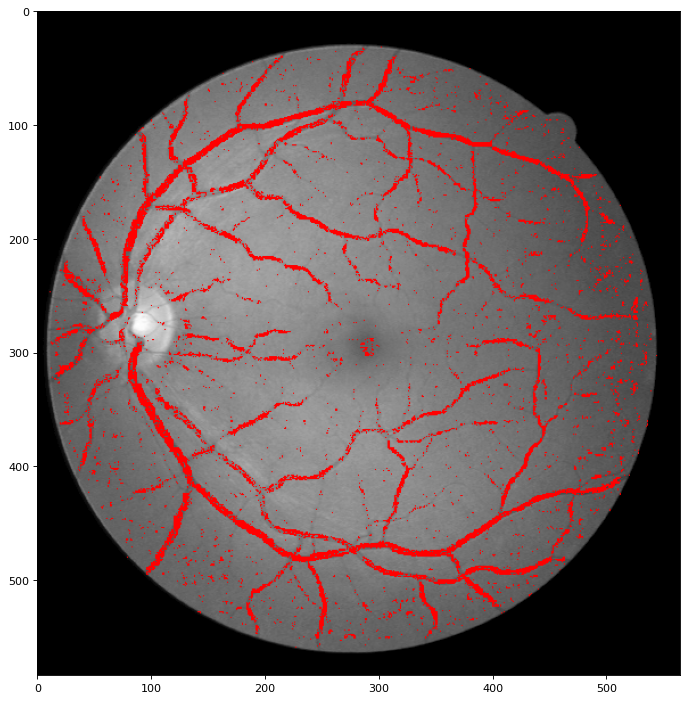

Accuracy score: 0.9066512463794492

F1 score: 0.5710132904370231

Confusion matrix:

     t/p      0     1 
        0 1150839 36706 
        1 90501 84661 
Sensivity: 0.4833297176328199
Specificity: 0.969090855504423


(0.907, 0.571, 1150839, 36706, 90501, 84661)

In [7]:
from main import *

PARAMETERS.LBP_METHOD = 'default'
PARAMETERS.METHOD = 'get_pyramid_dataset'
PARAMETERS.INTERPOLATION_ALGORITHM = 'lanczos'
PARAMETERS.BALANCE = False
PARAMETERS.N_SCALES = 5
PARAMETERS.GRAY_INTENSITY = True
PARAMETERS.X2SCALE = True
PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)
PARAMETERS.PLOT = True

PARAMETERS.CONVOLUTION = None
main(lgb=True, plot_once=True)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.347213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


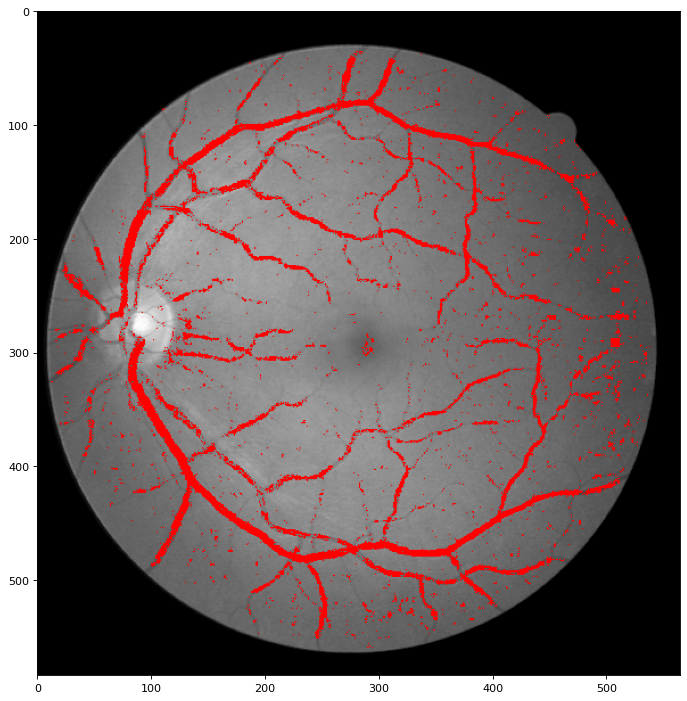

Accuracy score: 0.9089393391242578

F1 score: 0.5847824850344483

Confusion matrix:

     t/p      0     1 
        0 1151236 36309 
        1 87780 87382 
Sensivity: 0.49886390883867504
Specificity: 0.9694251586255679


(0.909, 0.585, 1151236, 36309, 87780, 87382)

In [8]:
main(lgb=True, plot_once=True, extra_features={'train': df_train_convolutions, 'test': df_test_convolutions})